<a href="https://colab.research.google.com/github/werowe/deepstate-map-data/blob/main/battlefield_gains_deepStateMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here is an extensive explanation of the logic and techniques used in your Jupyter Notebook.

Following the explanation, I have provided a **Python script** that you can run to automatically generate the new, heavily annotated .ipynb file.

### **Part 1: Detailed Code Explanation**

This notebook performs a sophisticated geospatial Extract-Transform-Load (ETL) process. It scrapes live war-zone data, cleanses geometry, verifies data freshness, validates topology, and exports the result.

#### **1\. Data Extraction (The API Hack)**

The script essentially "hacks" the DeepStateMap frontend by calling its backend API directly.

* **Discovery:** The markdown explains using the Browser's "Network Tab" to find hidden API calls (XHR/Fetch).  
* **Request:** It uses requests.get() to hit https://deepstatemap.live/api/history/last.  
* **Significance:** Instead of scraping HTML (which is messy), this retrieves the raw GeoJSON data used to render the map, providing the highest possible fidelity.

#### **2\. Geometry Flattening (The 3D to 2D Fix)**

The raw data comes in (Longitude, Latitude, Altitude) or (X, Y, Z) format.

* **The Problem:** Most 2D mapping libraries (like Matplotlib or standard Shapefiles) struggle with the Z-axis (Altitude), or it causes errors during topological operations (like intersections).  
* **The Solution:** The code uses a serialization trick:  
  Python

```

wkt.loads(wkt.dumps(shape(geom), output_dimension=2))
```

*   
  It converts the shape to a text representation (WKT), forces it to 2 dimensions (dropping Z), and converts it back to a geometric object.

#### **3\. Data Parsing & Translation**

The name field in the raw data contains a string separated by /// (e.g., "Ukrainian Text /// English Text /// Code").

* **Logic:** A custom function extract\_first\_part splits this string and grabs index 1 (the English text) to make the dataset internationally readable.

#### **4\. Geospatial Filtering**

The dataset contains mixed types: Points (cities, events) and Polygons (territories).

* **Type Filtering:** gdf.geometry.apply(lambda x: isinstance(x, Polygon)) creates a mask to keep only territorial shapes, discarding points.  
* **Attribute Filtering:** It filters the dataframe for specific keys: \['CADR and CALR', 'Occupied', 'Occupied Crimea'\]. This isolates the Russian-controlled territories from liberated or contested zones.

#### **5\. Data Verification (The "Contains" Check)**

To ensure the map isn't stale, the script performs a "Point-in-Polygon" test.

* **Control Point:** A hardcoded coordinate (\_latest\_rus\_advance) representing a very recent frontline change is created.  
* **Logic:** occupied\_ua\_gdf\_raw.contains(point) checks if this new point physically sits inside the downloaded polygons. If True, the map data is current.

#### **6\. Topological Merging & Repair (The Buffer Trick)**

This is the most advanced part of the script.

* **Union:** union\_all() merges hundreds of small polygons into one giant shape (Multipolygon).  
* **Artifacts:** Merging often creates "slivers" or "ghost gaps" due to floating-point math errors at polygon boundaries.  
* **The Fix (Buffer/Debuffer):**  
  * **Buffer (+$\\epsilon$):** Expands the shape outward by a tiny fraction ($0.000009$). This forces edges to overlap and snaps gaps shut.  
  * **Buffer (-$\\epsilon$):** Shrinks the shape back by the same amount.  
  * **Result:** The general shape is preserved, but internal artifacts/holes are healed.

#### **7\. Validation & CRS Projection**

* **Projection:** Coordinates are transformed from EPSG:4326 (Lat/Lon, measured in degrees) to EPSG:9835 (a local projection for Donetsk/Ukraine, measured in meters).  
* **Area Check:** It calculates the area of the original shape vs. the healed shape. The difference is 0.000027%, proving the repair altered the geometry only microscopically (removing artifacts) without corrupting the data.

---

### **Part 2: Generator Script**

Run the following Python block. It will create a file named annotated\_DeepStateMap.ipynb in your current directory. This new file contains your original code, but broken down with Markdown cells explaining every step in detail, and inline comments for complex lines.

# What is Shapely

Shapely is a Python package used for the manipulation and analysis of planar geometric objects.​

Core Capabilities
It allows you to create geometric objects such as Points, LineStrings, and Polygons using standard Python classes. Once created, you can perform various operations on these objects, including:​

Set-theoretic operations: Union, intersection, difference, and symmetric difference.​

Constructive operations: Creating buffers, centroids, and convex hulls.​

Measurement: Calculating area, length, and distance between geometries.​



###Basic Usage Example
Here is how you might create a simple point and a line using Shapely:


`from shapely.geometry import Point, LineString`

### Create a point at coordinates (1, 1)
`point = Point(1, 1)`

### Create a line from three points
`line = LineString([(0, 0), (3, 1), (0, 3)])`

# DeepStateMap Geospatial ETL Pipeline

## 1. Environment Setup
Importing necessary libraries for HTTP requests (`requests`), handling geospatial dataframes (`geopandas`), geometric manipulation (`shapely`), and visualization (`matplotlib`).

In [ ]:
import requests
import geopandas as gpd
from shapely.geometry import shape
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely import wkt
from shapely.geometry import JOIN_STYLE
import matplotlib.pyplot as plt

## 2. API Extraction Strategy
Instead of scraping HTML, we target the backend API directly. This provides the raw GeoJSON data used by the website to render the map.

**Note:** This endpoint (`api/history/last`) retrieves the current state of the map.

In [ ]:
url = 'https://deepstatemap.live/api/history/last'

# Execute GET request to fetch raw map state
response = requests.get(url)

# Check HTTP 200 (Success)
response.status_code

200

In [ ]:
deep_state_data_raw = response.json()

# Inspect top-level keys to ensure structure matches expectations
print(deep_state_data_raw.keys())
print(deep_state_data_raw['map'].keys())

dict_keys(['id', 'map', 'datetime'])
dict_keys(['type', 'features'])


In [ ]:
deep_state_data_raw['map']

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[37.8413435, 48.6832309, 0],
      [37.8289785, 48.681153, 0],
      [37.8258865, 48.6764872, 0],
      [37.8360112, 48.6739748, 0],
      [37.829922, 48.660611, 0],
      [37.805553, 48.649176, 0],
      [37.80645, 48.638348, 0],
      [37.7938557, 48.6338159, 0],
      [37.7952349, 48.6249989, 0],
      [37.7743365, 48.6224808, 0],
      [37.76089, 48.612774, 0],
      [37.763666, 48.600853, 0],
      [37.781832, 48.594208, 0],
      [37.7900567, 48.5947081, 0],
      [37.7924885, 48.5914907, 0],
      [37.7925457, 48.5895414, 0],
      [37.798096, 48.5898629, 0],
      [37.803217, 48.591149, 0],
      [37.80758, 48.591422, 0],
      [37.809174, 48.589303, 0],
      [37.808794, 48.586617, 0],
      [37.813714, 48.586386, 0],
      [37.815831, 48.582636, 0],
      [37.82151, 48.57971, 0],
      [37.828016, 48.577931, 0],
      [37.833154, 48.576184, 0],
      [37.832

In [ ]:
deep_state_data_raw['map']['features']

[{'type': 'Feature',
  'geometry': {'type': 'Polygon',
   'coordinates': [[[37.8413435, 48.6832309, 0],
     [37.8289785, 48.681153, 0],
     [37.8258865, 48.6764872, 0],
     [37.8360112, 48.6739748, 0],
     [37.829922, 48.660611, 0],
     [37.805553, 48.649176, 0],
     [37.80645, 48.638348, 0],
     [37.7938557, 48.6338159, 0],
     [37.7952349, 48.6249989, 0],
     [37.7743365, 48.6224808, 0],
     [37.76089, 48.612774, 0],
     [37.763666, 48.600853, 0],
     [37.781832, 48.594208, 0],
     [37.7900567, 48.5947081, 0],
     [37.7924885, 48.5914907, 0],
     [37.7925457, 48.5895414, 0],
     [37.798096, 48.5898629, 0],
     [37.803217, 48.591149, 0],
     [37.80758, 48.591422, 0],
     [37.809174, 48.589303, 0],
     [37.808794, 48.586617, 0],
     [37.813714, 48.586386, 0],
     [37.815831, 48.582636, 0],
     [37.82151, 48.57971, 0],
     [37.828016, 48.577931, 0],
     [37.833154, 48.576184, 0],
     [37.832539, 48.570307, 0],
     [37.840678, 48.563293, 0],
     [37.8309175, 4

## 4. Geometry flattening (3D to 2D)
**Critical Step:** The API returns coordinates in `(x, y, z)` format (Longitude, Latitude, Altitude). Most 2D analysis tools fail if Z-coordinates are present.

We loop through the features and use `shapely.wkt` to serialize the shape to text while forcing `output_dimension=2`, effectively dropping the Z-axis.

In [ ]:
geo_list = []

for f in deep_state_data_raw['map']['features']:
    geom = f['geometry']
    name = f['properties']['name']

    # Convert raw dict to Shape object -> Dump to WKT (Text) forcing 2D -> Load back to Shape
    # This effectively strips the 'Z' coordinate
    clean_geometry = wkt.loads(wkt.dumps(shape(geom), output_dimension=2))

    new_feature = {
      "name": name,
      "geometry": clean_geometry
    }

    geo_list.append(new_feature)

# Check total count of features retrieved
print(f"Total features extracted: {len(geo_list)}")

Total features extracted: 523


## 6. GeoDataFrame Construction
We convert the list of dicts into a `GeoDataFrame`. We explicitly set the CRS (Coordinate Reference System) to **EPSG:4326** (WGS84 - Standard Latitude/Longitude).

## Explanation of code below

1. `raw_deepstatemap_gdf = gpd.GeoDataFrame(geo_list)`
What it does: This converts geo_list (which is a standard Python list of dictionaries) into a GeoDataFrame.

Why it matters: A GeoDataFrame is the core data structure of the geopandas library. It looks like a standard Excel spreadsheet or Pandas DataFrame, but it has a special "geometry" column that understands shapes (Points, Polygons). This allows you to perform spatial operations like calculating areas, merging boundaries, or checking if a point is inside a region.

2. `raw_deepstatemap_gdf = raw_deepstatemap_gdf.set_crs(4326)`
What it does: This tells the GeoDataFrame that the coordinates inside it are using the EPSG:4326 standard.

The Translation: EPSG:4326 is the code for WGS84, which is the standard latitude/longitude system used by GPS, Google Maps, and most online mapping tools.

Why it matters: Without this line, the computer just sees numbers like (37.5, 48.2). By setting the CRS, you are telling the computer, "These numbers represent degrees on the curved surface of the Earth." This is critical for accurate mapping and area calculations later.

In [ ]:
def extract_first_part(name, part=0):
    """Splits the DeepState name string and returns the specific index requested."""
    first_part = name.split('///')[part].strip()
    return first_part

# Apply translation to all items in the list (Index 1 = English)
for item in geo_list:
    item['name'] = extract_first_part(item['name'], part=1)

In [ ]:
raw_deepstatemap_gdf = gpd.GeoDataFrame(geo_list)
raw_deepstatemap_gdf = raw_deepstatemap_gdf.set_crs(4326)


In [ ]:
points = raw_deepstatemap_gdf[
    raw_deepstatemap_gdf.geometry.apply(lambda x: isinstance(x, Point))
].copy()

print(f"Polygons remaining: {len(points)}")

Polygons remaining: 408


In [ ]:
points

,name,geometry
110,Russian cruiser Moskva,POINT (30.92515 45.17872)
111,Direction of attack,POINT (36.82591 48.06571)
112,Direction of attack,POINT (37.70018 49.50677)
113,Kyiv,POINT (30.52424 50.45006)
114,Minsk,POINT (27.55887 53.90216)
...,...,...
518,Air Base Ostrov,POINT (28.42118 57.29159)
519,Akhtubinsk Aerodrom,POINT (46.20243 48.30862)
520,Volgograd International Airport,POINT (44.34387 48.78517)
521,Airport «Vytyazevo»,POINT (37.34117 45.00282)


In [ ]:
polygons = raw_deepstatemap_gdf[
    raw_deepstatemap_gdf.geometry.apply(lambda x: isinstance(x, Polygon))
].copy()

print(f"Polygons remaining: {len(polygons)}")

Polygons remaining: 115


set_crs(4326) only labels the data as WGS84 lat/lon in degrees; you still need to reproject to a meter-based CRS before using .area for meaningful areas

In [ ]:
polygons = polygons.to_crs(epsg=32636)

In [ ]:
polygons['name'].unique()

array(['Unknown status', 'Occupied', 'Transnistria',
       'Occupied Tskhinvali district', 'Occupied Tuzla Island',
       'CADR and CALR', 'Occupied Crimea',
       'East Prussia is temporarily occupied.', 'Occupied Abkhazia.',
       'The temporarily occupied territory of Karelia.',
       'The temporarily occupied territory of the Republic of Ichkeria.',
       'Liberated', 'Liberated 25.03', 'Liberated 16.03-17.03',
       'Liberated 23.03', 'Liberated 27-31.03', 'Liberated 26.03',
       'Liberated 27-29.03', 'Liberated 30.03', 'Liberated 05.04',
       'Liberated 31.03', 'Liberated 02.07', 'Liberated 30.05',
       'Snake Island', 'Liberated 26.06', 'Liberated 04.09',
       'Occupied Petsamo', 'Occupied Salla',
       'occupied Estonia territories.',
       'Occupied Pechorsky district (Saaste Boot).',
       'Occupied Latvia territories.', 'Occupied Southern Kuril islands.',
       'Liberated 31.03 - 02.04'], dtype=object)

In [ ]:
targets = ['CADR and CALR', 'Occupied', 'Occupied Crimea']

occupied_areas = polygons[
     polygons['name'].isin(targets)
].copy().reset_index()



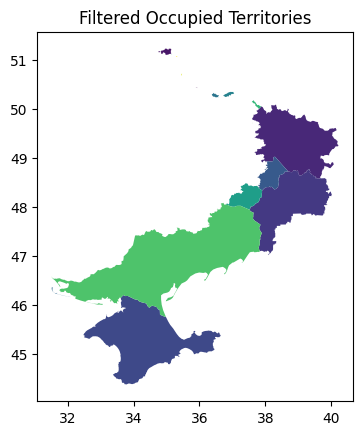

In [ ]:
occupied_areas.plot(cmap='viridis')
plt.title("Occupied Territories")
plt.show()



In [ ]:
liberated_areas = polygons[
    polygons["name"].str.contains("liberated", case=False, na=False)
].copy().reset_index(drop=True)

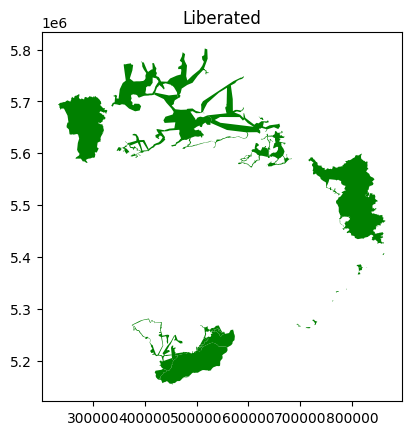

In [ ]:
liberated_areas.plot(color="green")
plt.title("Liberated")
plt.show()

In [ ]:
gray_areas = polygons[
    polygons["name"].str.contains("unknown", case=False, na=False)
].copy().reset_index(drop=True)


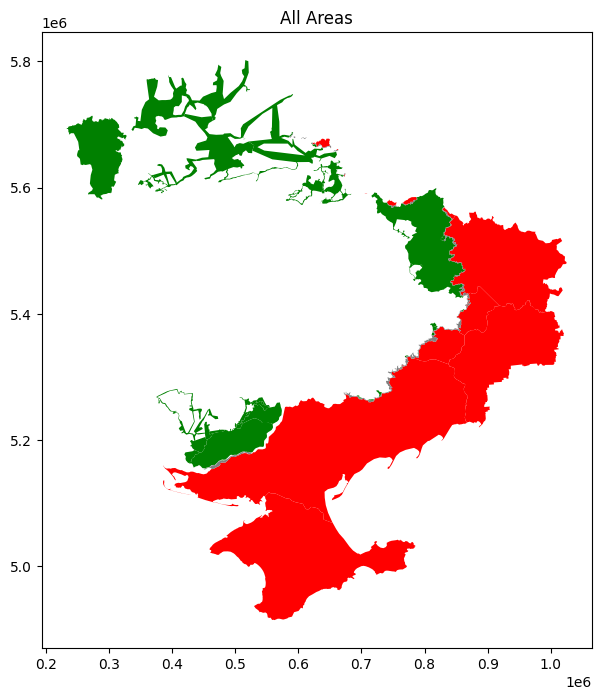

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

occupied_areas.plot(ax=ax, color="red")
liberated_areas.plot(ax=ax, color="green")
gray_areas.plot(ax=ax, color="gray")

ax.set_title("All Areas")
plt.show()


In [ ]:
km = 1000000

print("liberated areas km²", int(liberated_areas.area.sum()/ km))
print("occupied areas km²", int(occupied_areas.area.sum() / km))
print("gray areas km²", int(gray_areas.area.sum()/ km))


liberated areas km² 41396
occupied areas km² 116264
gray areas km² 1373


In [ ]:
from ipyleaflet import Map, basemaps, GeoJSON, LayerGroup, CircleMarker, Popup
from ipywidgets import HTML
from shapely.geometry import mapping
from IPython.display import display

def visualize_polygon_with_points(polygon_row, points_gdf):
    """
    Visualizes a single polygon and multiple points.
    CLICK a point to see its name (Popup).
    """

    # 1. Geometry & Map Setup
    poly_geom = polygon_row.geometry
    centroid = poly_geom.centroid
    m = Map(
        center=(centroid.y, centroid.x),
        zoom=10,
        basemap=basemaps.OpenStreetMap.Mapnik
    )

    # 2. Polygon Layer
    poly_layer = GeoJSON(
        data={
            "type": "Feature",
            "geometry": mapping(poly_geom),
            "properties": {"name": "Target Polygon"}
        },
        style={"color": "red", "weight": 3, "fillColor": "red", "fillOpacity": 0.2}
    )
    m.add(poly_layer)

    # 3. Point Layer Group
    point_group = LayerGroup()
    minx, miny, maxx, maxy = poly_geom.bounds

    for idx, point_row in points_gdf.iterrows():
        pt_geom = point_row.geometry
        label_text = str(point_row.get('name_left', point_row.get('name', f"Pt {idx}")))

        # Create Marker
        marker = CircleMarker(
            location=(pt_geom.y, pt_geom.x),
            radius=5,
            color="blue",
            fill_color="blue",
            fill_opacity=0.8,
            weight=1,
            draggable=False
        )

        # Attach Popup (Click behavior)
        message = HTML()
        message.value = f"<b>{label_text}</b>"
        marker.popup = message  # Assign the HTML widget to the popup

        point_group.add_layer(marker)

        # Update bounds
        minx = min(minx, pt_geom.x)
        miny = min(miny, pt_geom.y)
        maxx = max(maxx, pt_geom.x)
        maxy = max(maxy, pt_geom.y)

    m.add(point_group)
    m.fit_bounds(((miny, minx), (maxy, maxx)))

    return m


m = visualize_polygon_with_points(target_polygon_row, matched_points)
display(m)
